# Urban Mobility Analysis Using OpenStreetMap and OSMnx

Urban mobility is the ease with which people move around cities is a key indicator of livability and sustainability. As cities grow, understanding their road networks and accessibility becomes vital for planning public transport, bike lanes, and pedestrian-friendly infrastructure.

This notebook explores mobility patterns, accessibility, and shortest path routing using OpenStreetMap data, leveraging Python libraries like `osmnx`, `networkx`, and `geopandas`.


---
Boeing, G. (2025). Modeling and analyzing urban networks and amenities with OSMnx. Geographical Analysis, 1–23. https://onlinelibrary.wiley.com/doi/10.1111/gean.70009

#Setup and Installation

#Let's installs the osmnx library, a powerful Python tool used:

OSMnx is a Python package to "Retrieve, model, analyze, and visualize street networks and other spatial data from OpenStreetMap."

The OpenStreetMap-Data are retrieved with Overpass and stored in a Geopandas Dataframe.

*  Download and analyze OpenStreetMap (OSM) data,
*  Extract features such as roads, buildings, and green spaces,
*  Work with network graphs for routing, accessibility, and urban analysis,
*  Export shapefiles or visualize urban infrastructure.

osmnx is especially useful in urban data science for exploring city layouts, calculating distances, and integrating OSM data with satellite imagery or statistical boundaries.

#NetworkX library
NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.


In [1]:
%pip install osmnx geopandas networkx matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.4 MB/s eta 0:00:00


#Data Source & Tools
**OpenStreetMap (OSM)**: Open-source geospatial data on streets, buildings, and points of interest.

**OSMnx**: Python library for acquiring, constructing, analyzing, and visualizing OSM street networks.

**NetworkX**: For graph-based network analysis.

**Matplotlib / Geopandas**: For mapping and spatial analysis.

#Code Example
Download street network data of the Area of San Francisco and build a topologically-corrected street network:

G = ox.graph_from_bbox(bbox, network_type="drive_service")
Area definition: Uses a bounding box (min_lat, max_lat, min_lon, max_lon) that you define manually or programmatically.

**Download extent**: Fetches all OSM roads intersecting that rectangular area, regardless of administrative boundaries.

**Shape**: Always rectangular in geographic space (unless later clipped to a shape).

**network_type**='drive_service' → includes drive network plus service roads, parking lot roads, alleys, and other minor access ways.

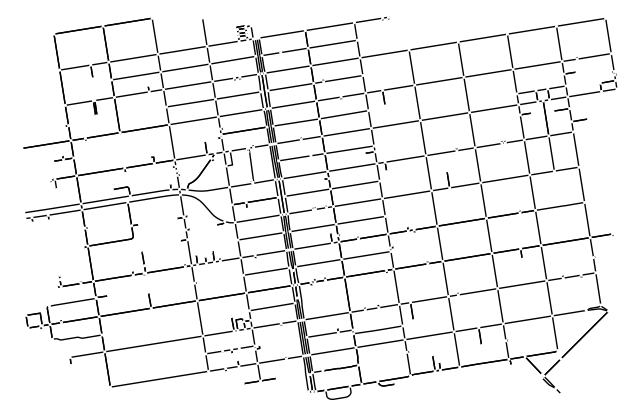

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
import osmnx as ox
bbox = -122.43, 37.78, -122.41, 37.79
G = ox.graph.graph_from_bbox(bbox, network_type="drive_service")
# Plot network
ox.plot_graph(G, bgcolor='white', node_size=5, edge_color='black')

#Reprojecting the file
**Original graph from OSM**:

Coordinates are in EPSG:4326 (degrees of latitude & longitude).

Distances aren’t in meters — you can’t directly measure lengths or areas accurately without converting.

**After project_graph**:

---



Coordinates are reprojected to the correct UTM CRS (Universal Transverse Mercator) for that location.

Units become meters, so edge lengths and distances can be calculated directly without haversine formulas.

OSMnx automatically stores the CRS in G.graph['crs'].

How OSMnx picks the UTM zone
It finds the centroid of your network in WGS84.

Determines the corresponding UTM zone based on longitude and hemisphere.

Reprojects all geometries into that zone’s EPSG code (e.g., EPSG:32610 for UTM zone 10N in the northern hemisphere).

In [3]:
print(G.graph["crs"])   # before: EPSG:4326 (WGS84, degrees)
#OSMnx takes your lat/lon (WGS 84) street network and reprojects it into the most appropriate UTM zone for the network’s geographic extent.

G_proj = ox.project_graph(G)
print(G_proj.graph["crs"])  # after: EPSG:32610 (UTM zone 10N, meters)

epsg:4326
EPSG:32610


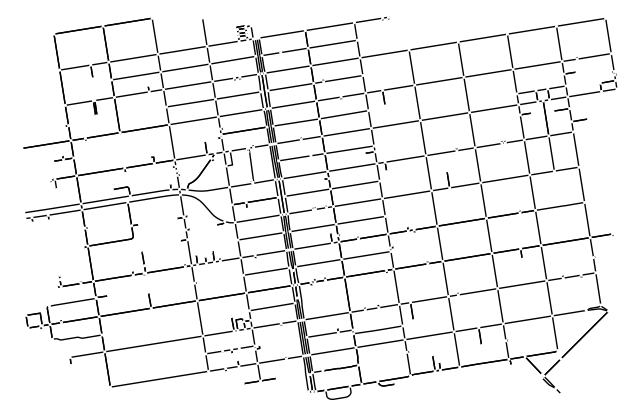

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
# Plot
ox.plot_graph(G, bgcolor="white", node_size=5, edge_color="black")

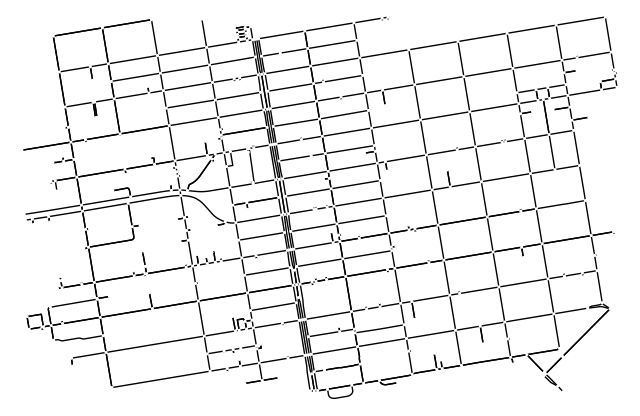

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
# Plot
ox.plot_graph(G_proj, bgcolor="white", node_size=5, edge_color="black")

In [7]:
#Convert to tables
# nodes_gdf: point features, edges_gdf: line features with attributes
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

In [8]:
# Quick looks
print("\n=== GRAPH METADATA (G.graph) ===")
for k, v in G.graph.items():
    print(f"{k}: {v}")


=== GRAPH METADATA (G.graph) ===
created_date: 2025-08-13 07:18:35
created_with: OSMnx 2.0.6
crs: epsg:4326
simplified: True


In [9]:
#lets do the same for projected file
print("\n GRAPH METADATA (G.graph) ")
for k, v in G_proj.graph.items():
    print(f"{k}: {v}")


 GRAPH METADATA (G.graph) 
created_date: 2025-08-13 07:18:35
created_with: OSMnx 2.0.6
crs: EPSG:32610
simplified: True


#This block is just an exploratory printout to quickly check:

How many nodes and what fields they have.

The data types of each field.

A small preview of actual attribute values.

In [ ]:
print("\n NODES: shape / columns ")
print(nodes_gdf.shape)
print(nodes_gdf.columns.tolist())
print("\nNodes dtypes:\n", nodes_gdf.dtypes)
print("\nNodes sample:\n", nodes_gdf.head(3))



 NODES: shape / columns 
(493, 5)
['y', 'x', 'street_count', 'highway', 'geometry']

Nodes dtypes:
 y                float64
x                float64
street_count       int64
highway           object
geometry        geometry
dtype: object

Nodes sample:
                   y           x  street_count highway  \
osmid                                                   
65281835  37.788048 -122.417920             3     NaN   
65281838  37.787636 -122.417836             1     NaN   
65285109  37.781285 -122.422196             3     NaN   

                             geometry  
osmid                                  
65281835  POINT (-122.41792 37.78805)  
65281838  POINT (-122.41784 37.78764)  
65285109   POINT (-122.4222 37.78128)  


Lets do the same for Edges

In [ ]:
print("\nEDGES: shape / columns")
print(edges_gdf.shape)
print(edges_gdf.columns.tolist())
print("\nEdges dtypes:\n", edges_gdf.dtypes)
print("\nEdges sample:\n", edges_gdf.head(3))


EDGES: shape / columns
(928, 14)
['osmid', 'highway', 'service', 'oneway', 'reversed', 'length', 'lanes', 'maxspeed', 'name', 'geometry', 'access', 'ref', 'tunnel', 'width']

Edges dtypes:
 osmid         object
highway       object
service       object
oneway          bool
reversed        bool
length       float64
lanes         object
maxspeed      object
name          object
geometry    geometry
access        object
ref           object
tunnel        object
width         object
dtype: object

Edges sample:
                             osmid      highway service  oneway  reversed  \
u        v        key                                                      
65281835 65281838 0       8915058      service   alley   False     False   
         65303554 0    1030275359  residential     NaN    True     False   
65281838 65281835 0       8915058      service   alley   False      True   

                          length lanes maxspeed           name  \
u        v        key                 

#Useful summaries

In [ ]:
# Length stats (meters) – available after projection
if "length" in edges_gdf.columns:
    print("\n=== Edge length stats (m) ===")
    print(edges_gdf["length"].describe())


=== Edge length stats (m) ===
count    928.000000
mean      54.839677
std       44.789441
min        1.870961
25%       15.980477
50%       48.211368
75%       76.196071
max      292.836602
Name: length, dtype: float64


#Load and Visualize the Street Network
**Area definition**: Uses a named place (from OSM’s Nominatim) to get a polygon boundary.

**Download extent**: Fetches all OSM roads that intersect the polygon.

**Shape**: Result matches the official administrative boundary of “Piedmont, California, USA.”

**network_type**='drive' → includes all drivable public roads suitable for motor vehicles (excludes service roads, private driveways, alleys unless marked as through roads).

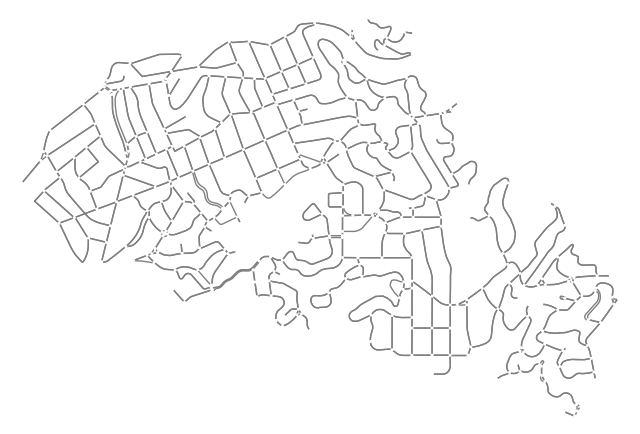

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

# Load driving network for a city
G = ox.graph_from_place('Piedmont, California, USA', network_type='drive')

# Plot network
ox.plot_graph(G, bgcolor='white', node_size=5, edge_color='gray')

In [ ]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Build & project the graph
place = "Piedmont, California, USA"
G = ox.graph_from_place(place, network_type="drive")

# Project to a local UTM CRS (meters) so length/area are meaningful
G = ox.project_graph(G)
print(G.graph["crs"])  # EPSG:32610 (UTM zone 10N, meters)


EPSG:32610


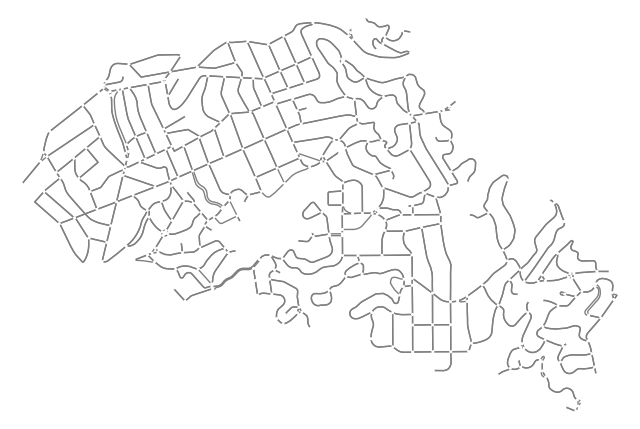

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
# Quick plot
ox.plot_graph(G, bgcolor="white", node_size=5, edge_color="gray")



In [ ]:
#  Quick metadata & basic stats
print("\n=== GRAPH METADATA ===")
for k, v in G.graph.items():
    print(f"{k}: {v}")

# OSMnx’s built-in stats (lengths, densities, circuity, etc.)
print("\n=== BASIC STATS (edges in meters) ===")
stats = ox.basic_stats(G)
for k, v in stats.items():
    if not isinstance(v, dict):
        print(f"{k}: {v}")




=== GRAPH METADATA ===
created_date: 2025-08-13 03:33:17
created_with: OSMnx 2.0.6
crs: EPSG:32610
simplified: True

=== BASIC STATS (edges in meters) ===
n: 352
m: 944
k_avg: 5.363636363636363
edge_length_total: 112049.01053896989
edge_length_avg: 118.6959857404342
streets_per_node_avg: 2.9488636363636362
intersection_count: 318
street_length_total: 58086.346128507765
street_segment_count: 495
street_length_avg: 117.34615379496518
circuity_avg: 1.1112792110333387
self_loop_proportion: 0.006060606060606061


In [ ]:
# Convert to GeoDataFrames
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)
print("\n=== NODES shape/columns ===", nodes_gdf.shape)
print(nodes_gdf.columns.tolist())
print("\nNodes dtypes:\n", nodes_gdf.dtypes)
print("\nNodes head():\n", nodes_gdf.head(3))

print("\n=== EDGES shape/columns ===", edges_gdf.shape)
print(edges_gdf.columns.tolist())
print("\nEdges dtypes:\n", edges_gdf.dtypes)
print("\nEdges head():\n", edges_gdf.head(3))



=== NODES shape/columns === (352, 6)
['y', 'x', 'street_count', 'highway', 'junction', 'geometry']

Nodes dtypes:
 y                float64
x                float64
street_count       int64
highway           object
junction          object
geometry        geometry
dtype: object

Nodes head():
                      y              x  street_count highway junction  \
osmid                                                                  
53017091  4.186804e+06  566214.413182             3     NaN      NaN   
53064327  4.186945e+06  566396.483295             3     NaN      NaN   
53075599  4.186687e+06  566181.072795             4     NaN      NaN   

                                geometry  
osmid                                     
53017091  POINT (566214.413 4186804.025)  
53064327  POINT (566396.483 4186944.568)  
53075599  POINT (566181.073 4186687.228)  

=== EDGES shape/columns === (944, 11)
['osmid', 'highway', 'name', 'oneway', 'reversed', 'length', 'geometry', 'lanes', 'maxspe

In [ ]:
# Attribute snapshots
# Highway tags can be strings or lists → normalize then count
def to_list(x):
    if pd.isna(x): return []
    return x if isinstance(x, list) else [x]

if "highway" in edges_gdf.columns:
    highway_counts = edges_gdf["highway"].apply(to_list).explode().value_counts()
    print("\n=== Highway types (counts) ===\n", highway_counts)


=== Highway types (counts) ===
 highway
residential      741
tertiary         157
secondary         38
unclassified       6
tertiary_link      2
Name: count, dtype: int64


In [ ]:
# Named vs unnamed streets
if "name" in edges_gdf.columns:
    named_pct = 100 * edges_gdf["name"].notna().mean()
    print(f"\nNamed edges: {named_pct:.1f}%")
# One-way distribution
if "oneway" in edges_gdf.columns:
    print("\n Oneway counts \n", edges_gdf["oneway"].value_counts(dropna=False))

# Length stats (meters)
if "length" in edges_gdf.columns:
    print("\n Edge length describe (m) \n", edges_gdf["length"].describe())

# Node street_count (how many incident streets)
if "street_count" in nodes_gdf.columns:
    print("\n Node street_count distribution \n",
          nodes_gdf["street_count"].value_counts().sort_index())



Named edges: 99.4%

 Oneway counts 
 oneway
False    898
True      46
Name: count, dtype: int64

 Edge length describe (m) 
 count    944.000000
mean     118.695986
std       90.844854
min        8.160134
25%       50.374176
50%       96.541818
75%      152.966893
max      550.838020
Name: length, dtype: float64

 Node street_count distribution 
 street_count
1     34
3    270
4     46
5      2
Name: count, dtype: int64


In [ ]:
# Add speeds & travel times
# Uses OSM tags + fallback assumptions; adds 'speed_kph' and 'travel_time' (seconds)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)  # refresh GDFs to include new columns

print("\n Speed/travel_time sample on edges \n",
      edges_gdf[["highway", "length", "speed_kph", "travel_time"]].head(5))


 Speed/travel_time sample on edges 
                            highway      length  speed_kph  travel_time
u        v        key                                                 
53017091 53064327 0    residential  230.124412  25.073051    33.041367
         53075599 0    residential  122.234915  25.073051    17.550544
53064327 53075602 0    residential  110.230343  25.073051    15.826923
         53064328 0    residential  123.704867  25.073051    17.761601
         53017091 0    residential  230.124412  25.073051    33.041367


In [ ]:
# Degree & connectivity
# Degree (undirected view so it's more intuitive)
#Gu = ox.utils_graph.get_undirected(G)
#degree_series = pd.Series(dict(Gu.degree()))
#print("\n=== Degree stats (undirected) ===\n", degree_series.describe())

try:
    # OSMnx ≥ 2 sometimes exposes helpers here
    from osmnx import graph as ox_graph
    try:
        Gu = ox_graph.to_undirected(G)  # if available
    except AttributeError:
        Gu = G.to_undirected(as_view=False)

    try:
        G_largest = ox_graph.largest_component(G, strongly=False)
    except AttributeError:
        components = list(nx.weakly_connected_components(G))
        G_largest = G.subgraph(max(components, key=len)).copy()

except Exception:
    # Fully fall back to NetworkX
    Gu = G.to_undirected(as_view=False)
    components = list(nx.weakly_connected_components(G))
    G_largest = G.subgraph(max(components, key=len)).copy()


In [ ]:
# Degree (undirected)
# Works on any version: use NetworkX directly
Gu = G.to_undirected(as_view=False)  # make a concrete undirected graph
degree_series = pd.Series(dict(Gu.degree()))
print("\nDegree stats (undirected)")
print(degree_series.describe())

# Largest component (weakly)
# For directed graphs use weakly connected components
components = list(nx.weakly_connected_components(G))
largest_nodes = max(components, key=len)
G_largest = G.subgraph(largest_nodes).copy()
print("\nLargest component nodes/edges:",
      G_largest.number_of_nodes(), G_largest.number_of_edges())


=== Degree stats (undirected) ===
count    352.000000
mean       2.829545
std        0.805559
min        1.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        5.000000
dtype: float64

Largest component nodes/edges: 352 944


In [ ]:
# Peek a single node/edge in full detail
# One node:
n_id, n_data = next(iter(G.nodes(data=True)))
print("\nOne node detail ")
print("node id:", n_id)
for k, v in n_data.items():
    print(f"  {k}: {v}")


One node detail 
node id: 53017091
  y: 4186804.0245126975
  x: 566214.4131818174
  street_count: 3


In [ ]:
# One edge (u, v, key) with all attributes:
u, v, k, e_data = next(iter(G.edges(keys=True, data=True)))
print("\n One edge detail \n")
print(f"(u={u}, v={v}, key={k})")
for k_attr, v_attr in e_data.items():
    print(f"  {k_attr}: {v_attr}")


 One edge detail 

(u=53017091, v=53064327, key=0)
  osmid: 6345781
  highway: residential
  name: Rose Avenue
  oneway: False
  reversed: False
  length: 230.12441194959652
  geometry: LINESTRING (566214.4131818174 4186804.0245126975, 566223.1458671754 4186808.155925568, 566396.4832948946 4186944.568205336)
  speed_kph: 25.07305072463768
  travel_time: 33.04136748722343


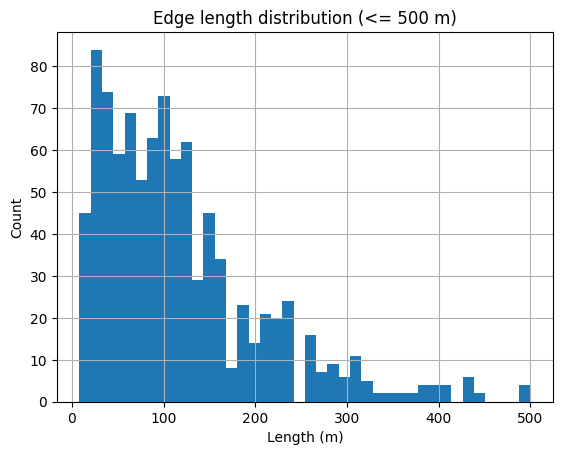

In [ ]:
# Simple visuals for distributions
# (a) Histogram of edge lengths
if "length" in edges_gdf.columns:
    plt.figure()
    edges_gdf["length"].clip(upper=500).hist(bins=40)  # clip long tails for readability
    plt.title("Edge length distribution (<= 500 m)")
    plt.xlabel("Length (m)")
    plt.ylabel("Count")
    plt.show()

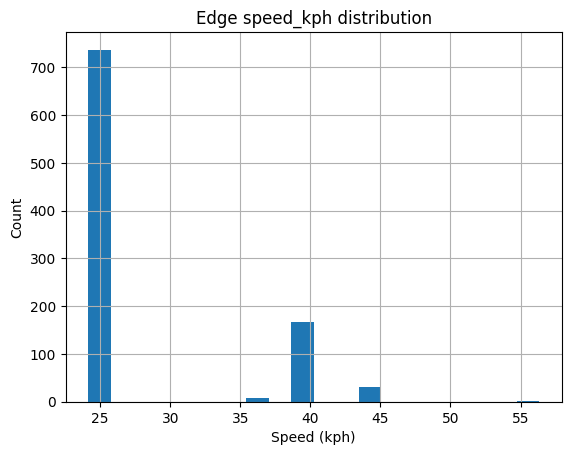

In [ ]:
# (b) Histogram of speeds (kph)
if "speed_kph" in edges_gdf.columns:
    plt.figure()
    edges_gdf["speed_kph"].dropna().hist(bins=20)
    plt.title("Edge speed_kph distribution")
    plt.xlabel("Speed (kph)")
    plt.ylabel("Count")
    plt.show()

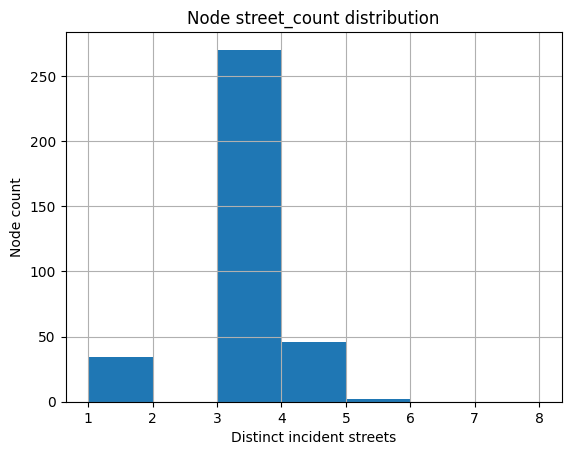

In [ ]:
# (c) Street count at nodes
if "street_count" in nodes_gdf.columns:
    plt.figure()
    nodes_gdf["street_count"].dropna().astype(int).hist(bins=range(1,9))
    plt.title("Node street_count distribution")
    plt.xlabel("Distinct incident streets")
    plt.ylabel("Node count")
    plt.show()

#Save the whole graph as GraphML
G is the full NetworkX MultiDiGraph.

save_graphml() writes it to GraphML, an XML-based graph format.

This keeps all nodes, edges, and their attributes.

In [ ]:
# Optional: save for GIS / later use
# Save to GeoPackage (keeps all attributes)
nodes_gdf.to_file("piedmont_nodes.gpkg", layer="nodes", driver="GPKG") #Save nodes as a GeoPackage
edges_gdf.to_file("piedmont_edges.gpkg", layer="edges", driver="GPKG") #Save edges as a GeoPackage
ox.save_graphml(G, "piedmont_drive.graphml")  # portable for Gephi/NetworkX/OSMnx


! Where are these saved?

If you use a local Python script, they’re saved in the same directory where you ran the script (unless you give an absolute path).

If you’re in Jupyter Notebook, they’ll be saved in the notebook’s working directory (%pwd shows this).

In Google Colab, they’re in the Colab VM’s /content/ directory unless you specify another path.

In [ ]:
import os

# --- Define file names ---
nodes_file = "piedmont_nodes.gpkg"
edges_file = "piedmont_edges.gpkg"
graphml_file = "piedmont_drive.graphml"

# --- Save to GeoPackage (keeps all attributes) ---
nodes_gdf.to_file(nodes_file, layer="nodes", driver="GPKG")   # Save nodes
edges_gdf.to_file(edges_file, layer="edges", driver="GPKG")   # Save edges
ox.save_graphml(G, graphml_file)                              # Save graph

# --- Verification helper function ---
def verify_file(path):
    abs_path = os.path.abspath(path)      # absolute path
    exists = os.path.exists(abs_path)     # check if file exists
    size = os.path.getsize(abs_path) / 1024 if exists else 0  # KB
    size_str = f"{size/1024:.2f} MB" if size > 1024 else f"{size:.1f} KB"

    print(f"\nFile: {abs_path}")
    print(f"  Exists: {exists}")
    if exists:
        print(f"  Size: {size_str}")

# --- Run verification ---
verify_file(nodes_file)
verify_file(edges_file)
verify_file(graphml_file)



File: /content/piedmont_nodes.gpkg
  Exists: True
  Size: 140.0 KB

File: /content/piedmont_edges.gpkg
  Exists: True
  Size: 400.0 KB

File: /content/piedmont_drive.graphml
  Exists: True
  Size: 643.9 KB


#Route Calculation

## Route Calculation

In this section, we calculate the shortest driving routes between two sets of points using **OpenStreetMap** data.

The routes are computed using **Dijkstra’s algorithm**, which finds the shortest path between two nodes in a graph based on edge weights — in this case, **road segment lengths** from the OSM street network.

---

### Example 1: Routing Across Cities (Longer Distance)

This example shows how to calculate a route across a broader urban area using a pair of origin and destination coordinates in different parts of the city.

---

In [ ]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

# Download the street network for a city
G = ox.graph_from_place('Piedmont, California, USA', network_type='drive')


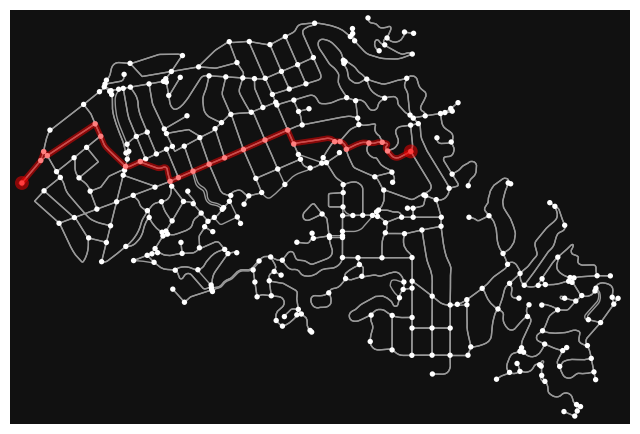

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
# Define origin and destination coordinates (longer distance)
origin = (37.8253, -122.2244)
destination = (37.7944, -122.4061)

# Get nearest nodes from the street network
origin_node = ox.distance.nearest_nodes(G, X=origin[1], Y=origin[0])
destination_node = ox.distance.nearest_nodes(G, X=destination[1], Y=destination[0])

# Compute shortest path using Dijkstra's algorithm
route = nx.shortest_path(G, origin_node, destination_node, weight='length')

# Plot the route
ox.plot_graph_route(G, route)



### Example 2: Routing Within a Neighborhood (Shorter Local Trip)

This example calculates a short route within a neighborhood — useful for understanding local connectivity and pedestrian accessibility.

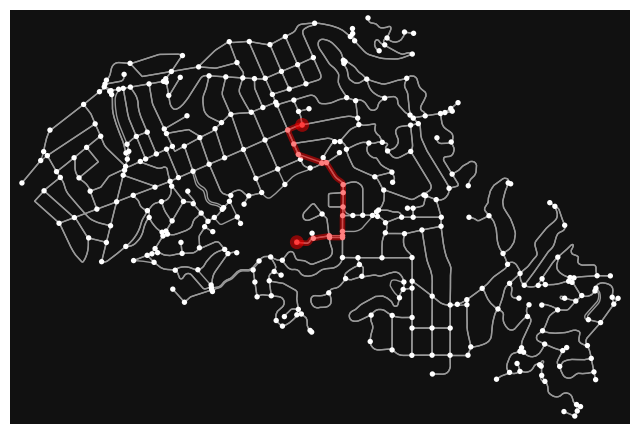

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:

# Define new origin and destination (closer, same neighborhood)
origin = (37.8207, -122.2323)
destination = (37.8265, -122.2322)

# Use the updated method to get nearest nodes
origin_node = ox.distance.nearest_nodes(G, X=origin[1], Y=origin[0])
destination_node = ox.distance.nearest_nodes(G, X=destination[1], Y=destination[0])

# Find the shortest path using Dijkstra
route = nx.shortest_path(G, origin_node, destination_node, weight='length')

# Plot the route
ox.plot_graph_route(G, route)

## Origin-Destination (OD) Matrix

An **Origin-Destination (OD) Matrix** is a key tool in transportation, mobility, and urban planning. It represents the volume or frequency of movement between various origin and destination points over a given time.

---

### Structure

An OD matrix is typically a table where:

- **Rows** represent **origin zones** (e.g., neighborhoods, grid cells, stations)
- **Columns** represent **destination zones**
- Each **cell** contains a value representing the number of trips, travel time, or cost from an origin to a destination.

#### Example:

|         | Destination 1 | Destination 2 | Destination 3 |
|---------|----------------|----------------|----------------|
| Origin 1 |      120       |       80        |       45        |
| Origin 2 |       60       |       150       |       30        |
| Origin 3 |       75       |       40        |      110        |

> *120 trips originated in zone 1 and ended in zone 1; 150 trips went from zone 2 to zone 2, and so on.*

---

### Applications

- Traffic demand modeling
- Public transit planning
- Accessibility analysis
- Urban flow visualizations
- Supply chain logistics

---

### Data Sources

- Travel surveys
- Mobile phone or GPS data
- Ticketing systems (e.g., smart cards)
- Routing tools like **OSMnx** or **OpenTripPlanner**

---

Maintaining a consistent **spatial reference** (e.g., CRS or zone definitions) is crucial when combining OD matrices with spatial layers such as road networks or administrative boundaries.


In [ ]:
# Define multiple origin-destination points (synthetic or sampled)
od_pairs = [
    ((37.8207, -122.2323), (37.8265, -122.2250)),
    ((37.8253, -122.2244), (37.7944, -122.4061)),
    ((37.8220, -122.2425), (37.8281, -122.2213)),
    ((37.8275, -122.2478), (37.8112, -122.2446)),
    ((37.8240, -122.2310), (37.8395, -122.2268))
    # Add more pairs...
]

# Compute shortest paths and distances
results = []
for i, (orig, dest) in enumerate(od_pairs):
    o_node = ox.distance.nearest_nodes(G, X=orig[1], Y=orig[0])
    d_node = ox.distance.nearest_nodes(G, X=dest[1], Y=dest[0])

    try:
        length = nx.shortest_path_length(G, o_node, d_node, weight='length')
        results.append({'origin': orig, 'destination': dest, 'distance_m': length})
    except nx.NetworkXNoPath:
        results.append({'origin': orig, 'destination': dest, 'distance_m': None})

import pandas as pd
od_df = pd.DataFrame(results)
od_df


origin           destination  distance_m
0  (37.8207, -122.2323)   (37.8265, -122.225)           0
1  (37.8253, -122.2244)  (37.7944, -122.4061)           0
2   (37.822, -122.2425)  (37.8281, -122.2213)           0
3  (37.8275, -122.2478)  (37.8112, -122.2446)           0
4    (37.824, -122.231)  (37.8395, -122.2268)           0

All 0’s means every origin and destination snapped to the same node before routing. That almost always happens when the graph is projected to UTM (meters) but you pass lat/lon (degrees) into nearest_nodes. nearest_nodes expects coordinates in the graph’s CRS.

In [ ]:
import osmnx as ox
import networkx as nx
import pandas as pd

place = "Piedmont, California, USA"

# Build unprojected graph (WGS84) for snapping
G_wgs = ox.graph_from_place(place, network_type="drive")  # EPSG:4326

# (Optional) project for analysis/plotting, but keep node ids
G = ox.project_graph(G_wgs)  # meters

od_pairs = [
    ((37.8207, -122.2323), (37.8265, -122.2250)),
    ((37.8253, -122.2244), (37.7944, -122.4061)),
    ((37.8220, -122.2425), (37.8281, -122.2213)),
    ((37.8275, -122.2478), (37.8112, -122.2446)),
    ((37.8240, -122.2310), (37.8395, -122.2268))
]

results = []
for (olat, olon), (dlat, dlon) in od_pairs:
    # snap in WGS84 (degrees)
    o_node = ox.distance.nearest_nodes(G_wgs, X=olon, Y=olat)
    d_node = ox.distance.nearest_nodes(G_wgs, X=dlon, Y=dlat)
    try:
        # compute on the projected graph (meters) using same node ids
        dist_m = nx.shortest_path_length(G, o_node, d_node, weight="length")
    except nx.NetworkXNoPath:
        dist_m = None
    results.append({"origin": (olat, olon), "destination": (dlat, dlon), "distance_m": dist_m})

od_df = pd.DataFrame(results)
print(od_df)


                 origin           destination   distance_m
0  (37.8207, -122.2323)   (37.8265, -122.225)  1385.559194
1  (37.8253, -122.2244)  (37.7944, -122.4061)  2681.456035
2   (37.822, -122.2425)  (37.8281, -122.2213)  2110.927573
3  (37.8275, -122.2478)  (37.8112, -122.2446)  1964.189893
4    (37.824, -122.231)  (37.8395, -122.2268)  2100.088428


#Convert OD Matrix to Heatmap or Table

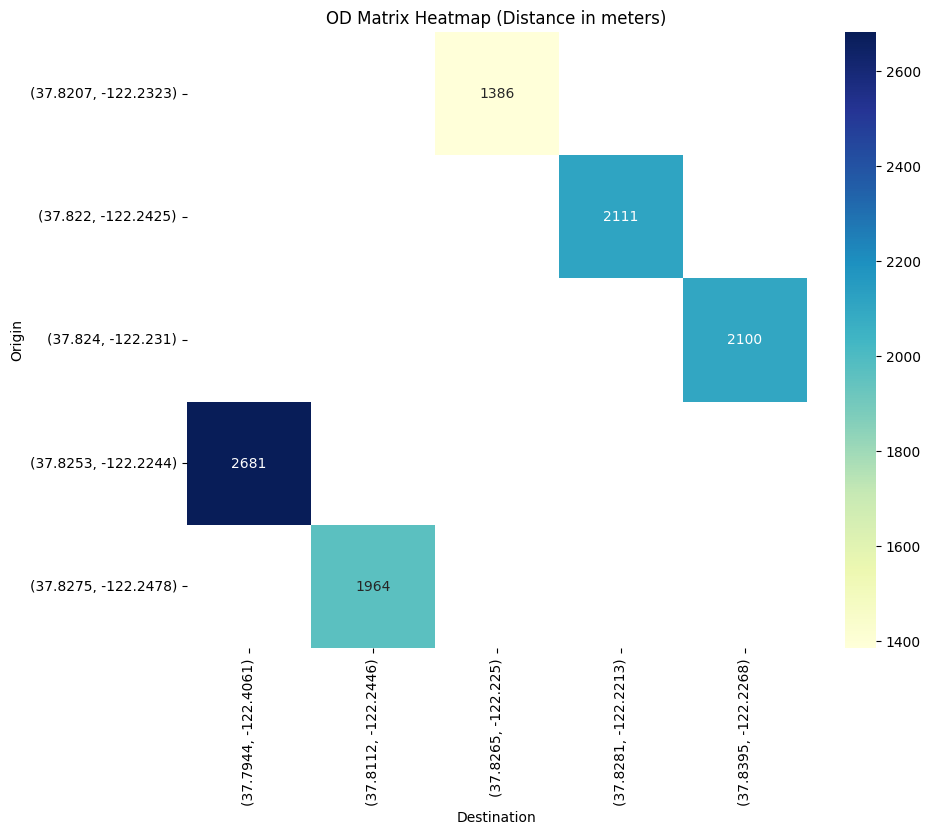

In [ ]:
import seaborn as sns

# If you have grid zones, pivot the table
od_df['origin_str'] = od_df['origin'].astype(str)
od_df['dest_str'] = od_df['destination'].astype(str)

pivot = od_df.pivot(index='origin_str', columns='dest_str', values='distance_m')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("OD Matrix Heatmap (Distance in meters)")
plt.xlabel("Destination")
plt.ylabel("Origin")
plt.show()


The current plot, only computed distances for the given OD pairs, not for all combinations of origins and destinations.

# How to make a full OD matrix (every origin to every destination), compute all pairwise shortest path distances on your OSMnx graph and put them in a 2D array.

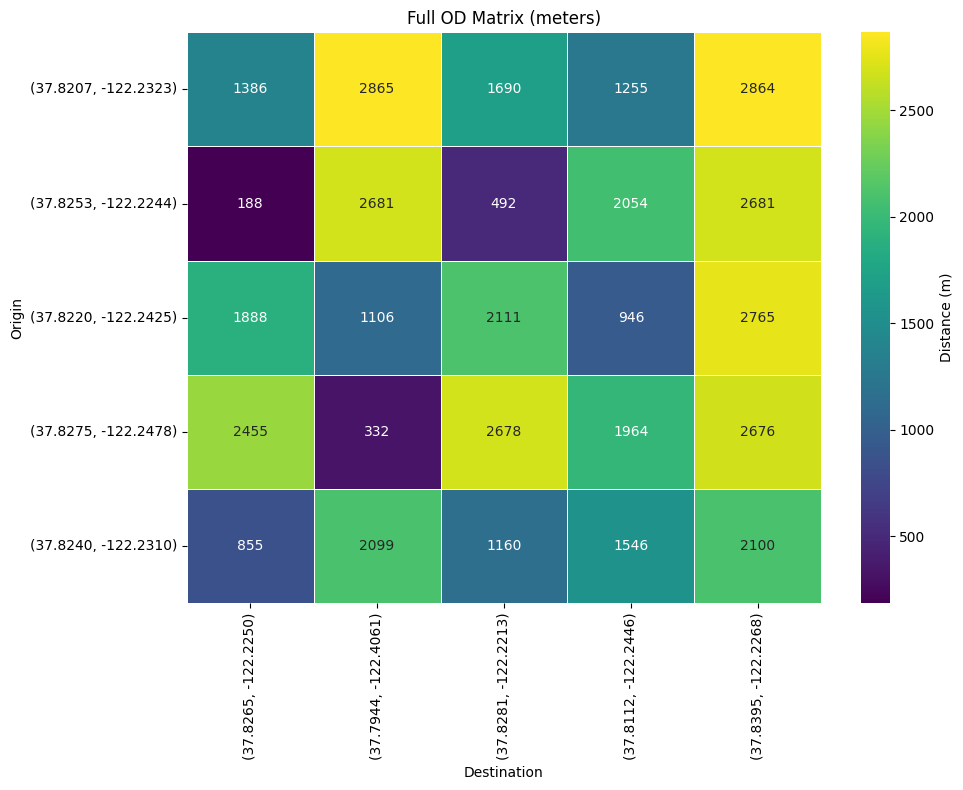

In [ ]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------- 0) Graph (snap in WGS84, compute on projected) -------------
place = "Piedmont, California, USA"
G_wgs = ox.graph_from_place(place, network_type="drive")  # EPSG:4326
G = ox.project_graph(G_wgs)                               # meters for distances
# (Optional) use time instead of meters:
# G = ox.add_edge_speeds(G); G = ox.add_edge_travel_times(G)
weight_attr = "length"   # or "travel_time"

# ---------------- 1) Define OD coordinates (lat, lon) ------------------------
od_pairs = [
    ((37.8207, -122.2323), (37.8265, -122.2250)),
    ((37.8253, -122.2244), (37.7944, -122.4061)),
    ((37.8220, -122.2425), (37.8281, -122.2213)),
    ((37.8275, -122.2478), (37.8112, -122.2446)),
    ((37.8240, -122.2310), (37.8395, -122.2268)),
]

# Make full lists (you can also set destinations = origins for a square matrix over the same points)
origins = [o for o, _ in od_pairs]
destinations = [d for _, d in od_pairs]

# ---------------- 2) Snap all coords to nearest graph nodes once -------------
def snap_many(coords, Gsnap):
    xs = [lon for lat, lon in coords]
    ys = [lat for lat, lon in coords]
    return ox.distance.nearest_nodes(Gsnap, X=xs, Y=ys)

orig_nodes = snap_many(origins, G_wgs)       # snap in WGS84 graph
dest_nodes = snap_many(destinations, G_wgs)  # (node ids are valid in projected G)

# ---------------- 3) Compute full OD matrix ---------------------------------
OD = np.full((len(orig_nodes), len(dest_nodes)), np.nan, dtype=float)

# Run Dijkstra once per origin, then read off distances to all destinations
for i, o in enumerate(orig_nodes):
    dist_to_all = nx.single_source_dijkstra_path_length(G, o, weight=weight_attr)
    for j, d in enumerate(dest_nodes):
        OD[i, j] = 0.0 if o == d else dist_to_all.get(d, np.nan)

# ---------------- 4) Build labeled DataFrame + heat map ----------------------
row_labels = [f"({lat:.4f}, {lon:.4f})" for lat, lon in origins]
col_labels = [f"({lat:.4f}, {lon:.4f})" for lat, lon in destinations]
od_df_full = pd.DataFrame(OD, index=row_labels, columns=col_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(
    od_df_full, annot=True, fmt=".0f", cmap="viridis",
    cbar_kws={"label": "Distance (m)" if weight_attr=="length" else "Travel time (s)"},
    linewidths=0.5, linecolor="white"
)
plt.title(f"Full OD Matrix ({'meters' if weight_attr=='length' else 'seconds'})")
plt.xlabel("Destination"); plt.ylabel("Origin"); plt.tight_layout(); plt.show()

# Optional: save
# od_df_full.to_csv("od_matrix.csv", index=True)


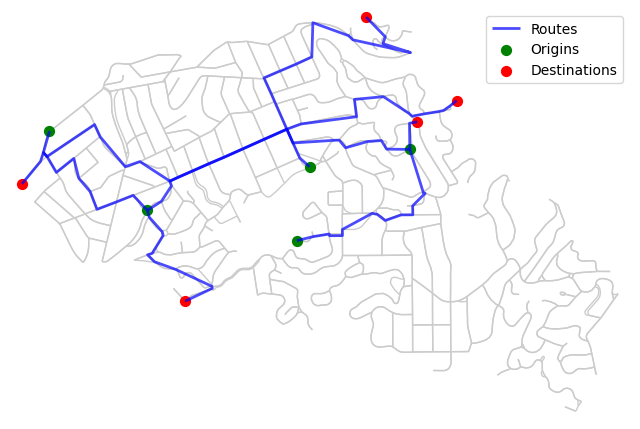

In [ ]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt

# Graphs (snap on WGS84, compute on projected) ---
place = "Piedmont, California, USA"
G_wgs = ox.graph_from_place(place, network_type="drive")
G = ox.project_graph(G_wgs)  # meters

# Origins & destinations ---
od_pairs = [
    ((37.8207, -122.2323), (37.8265, -122.2250)),
    ((37.8253, -122.2244), (37.7944, -122.4061)),
    ((37.8220, -122.2425), (37.8281, -122.2213)),
    ((37.8275, -122.2478), (37.8112, -122.2446)),
    ((37.8240, -122.2310), (37.8395, -122.2268)),
]

# Snap points to nearest nodes ---
def snap(lat, lon):
    return ox.distance.nearest_nodes(G_wgs, X=lon, Y=lat)

routes = []
origin_points = []
dest_points = []

for (olat, olon), (dlat, dlon) in od_pairs:
    o_node = snap(olat, olon)
    d_node = snap(dlat, dlon)

    try:
        path = nx.shortest_path(G, o_node, d_node, weight="length")
        # Convert path to LineString
        coords = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in path]
        routes.append(LineString(coords))
        origin_points.append(Point(G.nodes[o_node]['x'], G.nodes[o_node]['y']))
        dest_points.append(Point(G.nodes[d_node]['x'], G.nodes[d_node]['y']))
    except nx.NetworkXNoPath:
        continue

# Create GeoDataFrames ---
routes_gdf = gpd.GeoDataFrame(geometry=routes, crs=G.graph["crs"])
origins_gdf = gpd.GeoDataFrame(geometry=origin_points, crs=G.graph["crs"])
dests_gdf = gpd.GeoDataFrame(geometry=dest_points, crs=G.graph["crs"])

# Plot network + OD routes ---
fig, ax = ox.plot_graph(G, node_size=0, edge_color="#cccccc",
                        bgcolor="white", show=False, close=False)

routes_gdf.plot(ax=ax, color="blue", linewidth=2, alpha=0.7, label="Routes")
origins_gdf.plot(ax=ax, color="green", markersize=50, label="Origins")
dests_gdf.plot(ax=ax, color="red", markersize=50, label="Destinations")

ax.legend()
plt.show()

#Advanced urban mobility analysis using open data and OSMnx.
Now lets explore the Berkeley, California as a study area



In [ ]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Download road network for multiple modes
city = 'Berkeley, California, USA'
G_drive = ox.graph_from_place(city, network_type='drive')
G_walk = ox.graph_from_place(city, network_type='walk')
G_bike = ox.graph_from_place(city, network_type='bike')


In [ ]:
%pip install --upgrade osmnx
import osmnx as ox
ox.__version__  # should be 1.1.1 or higher

'2.0.6'

#Accessibility Analysis (Distance to Hospitals)

In [ ]:
# Get hospitals from OpenStreetMap
place = "Berkeley, California, USA"
tags = {"amenity": "hospital"}
hospitals = ox.features_from_place(place, tags)
#tags = {"amenity": "hospital"}
#hospitals = ox.geometries_from_place(city, tags)

In [ ]:
# Get sample residential points (you can refine later)
residential_nodes = list(G_drive.nodes())[:500]  # Sample 500 starting points

In [ ]:
# Get nearest hospital nodes
hospital_points = hospitals[['geometry']].centroid
hospital_nodes = [ox.distance.nearest_nodes(G_drive, p.x, p.y) for p in hospital_points.geometry]



/tmp/ipython-input-3740343630.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hospital_points = hospitals[['geometry']].centroid


In [ ]:
# Print counts
print("Counts")
print("------")
print(f"Buildings (features): {len(buildings)}")
print(f"Hospitals (features): {len(hospitals)}")
print(f"Sampled residential origin nodes: {len(residential_nodes)}")

Counts
------
Buildings (features): 35725
Hospitals (features): 2
Sampled residential origin nodes: 500


In [ ]:
# If you also want the number of distinct hospital *network nodes* used:
print(f"Hospital nodes (unique after snapping): {len(set(hospital_nodes))}")

Hospital nodes (unique after snapping): 2


In [ ]:
# Print CRS info ---
# GeoDataFrame CRS:
print("\nCRS")
print("---")
print("Hospitals GDF CRS:", hospitals.crs)
print("Buildings GDF CRS:", buildings.crs)



CRS
---
Hospitals GDF CRS: epsg:4326
Buildings GDF CRS: epsg:4326


In [ ]:
# Compute shortest distance from each origin to nearest hospital
results = []
for origin in residential_nodes:
    try:
        distances = [
            nx.shortest_path_length(G_drive, origin, h, weight='length') for h in hospital_nodes
        ]
        results.append(min(distances))
    except:
        results.append(None)

print("Average distance to nearest hospital (m):", pd.Series(results).mean())


Average distance to nearest hospital (m): 3204.666415411592


#Visualize Nearest Hospital Distances

/tmp/ipython-input-293382311.py:28: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  hospital_nodes = list(pd.unique(hospital_nodes))  # unique nodes only


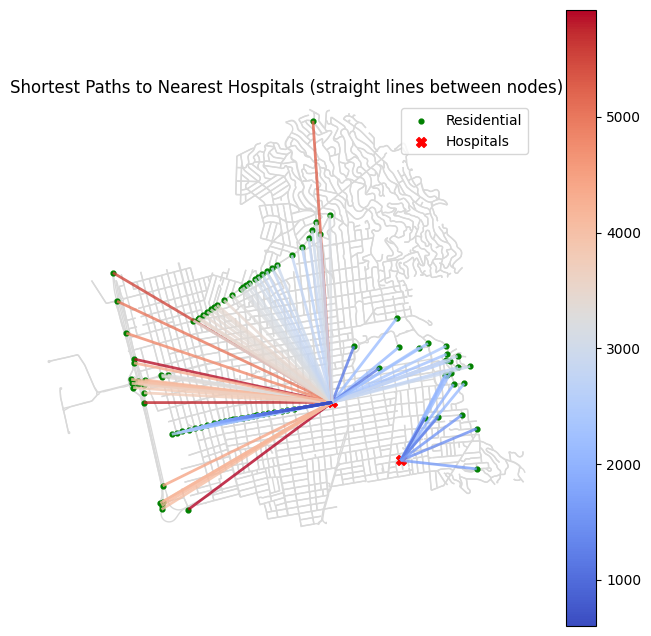

=== Summary ===
Place: Berkeley, California, USA
Street graph CRS (WGS):   epsg:4326
Street graph CRS (UTM):   EPSG:32610
Hospitals (features):     2
Hospitals (nodes, uniq):  2
Residential nodes used:   100

Distance to nearest hospital (meters):
  count:  100
  mean:   2785.7
  median: 2842.9
  min:    600.4
  max:    5924.1


In [ ]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import numpy as np

place = "Berkeley, California, USA"

# 0) Build graphs
G_wgs  = ox.graph_from_place(place, network_type="drive")  # EPSG:4326 (degrees) – best for snapping
G_proj = ox.project_graph(G_wgs)                            # local UTM (meters) – best for distances/plotting

# 1) Get hospitals (WGS84), compute centroids in *projected* CRS for accuracy, then keep projected
tags = {"amenity": "hospital"}
hospitals_wgs = ox.features_from_place(place, tags).pipe(lambda g: g[g.geometry.notna()].copy())

hospitals_proj = hospitals_wgs.to_crs(G_proj.graph["crs"])
hospital_points_proj = hospitals_proj.geometry.centroid    # points in projected CRS (meters)

# 2) Snap hospital centroids to network nodes (use WGS graph for snapping; node IDs match in both graphs)
hospital_points_wgs = hospital_points_proj.to_crs("EPSG:4326")
hospital_nodes = [
    ox.distance.nearest_nodes(G_wgs, X=p.x, Y=p.y)
    for p in hospital_points_wgs.geometry if p.is_valid and not p.is_empty
]
hospital_nodes = list(pd.unique(hospital_nodes))  # unique nodes only

# 3) Sample residential origin nodes (WGS), then use same node IDs on projected graph
residential_nodes = list(G_wgs.nodes())[:100]  # take first 100 for demo

# 4) For each origin, route to nearest hospital on the projected graph (meters)
lines, distances = [], []
for origin in residential_nodes:
    try:
        dists = [nx.shortest_path_length(G_proj, origin, h, weight="length") for h in hospital_nodes]
        if not dists:
            continue
        min_dist = float(np.min(dists))
        nearest_h = hospital_nodes[int(np.argmin(dists))]

        # Build straight line between origin node and hospital node for visualization
        ox1, oy1 = G_proj.nodes[origin]["x"], G_proj.nodes[origin]["y"]
        ox2, oy2 = G_proj.nodes[nearest_h]["x"], G_proj.nodes[nearest_h]["y"]
        lines.append(LineString([(ox1, oy1), (ox2, oy2)]))
        distances.append(min_dist)
    except nx.NetworkXNoPath:
        continue

# 5) GeoDataFrames for plotting (projected CRS)
lines_gdf = gpd.GeoDataFrame({"distance_m": distances}, geometry=lines, crs=G_proj.graph["crs"])
res_pts   = gpd.GeoDataFrame(geometry=[Point(G_proj.nodes[n]["x"], G_proj.nodes[n]["y"]) for n in residential_nodes],
                             crs=G_proj.graph["crs"])
hosp_pts  = gpd.GeoDataFrame(geometry=[Point(G_proj.nodes[n]["x"], G_proj.nodes[n]["y"]) for n in hospital_nodes],
                             crs=G_proj.graph["crs"])

# 6) Plot
fig, ax = ox.plot_graph(G_proj, node_size=0, edge_color="#d9d9d9",
                        bgcolor="white", show=False, close=False)
lines_gdf.plot(ax=ax, column="distance_m", cmap="coolwarm", linewidth=2, alpha=0.8, legend=True)
res_pts.plot(ax=ax, color="green", markersize=12, label="Residential")
hosp_pts.plot(ax=ax, color="red", marker="X", markersize=50, label="Hospitals")
ax.legend()
ax.set_title("Shortest Paths to Nearest Hospitals (straight lines between nodes)")
plt.show()

# 7) Clear, informative prints
print("=== Summary ===")
print(f"Place: {place}")
print(f"Street graph CRS (WGS):   {G_wgs.graph.get('crs')}")
print(f"Street graph CRS (UTM):   {G_proj.graph.get('crs')}")
print(f"Hospitals (features):     {len(hospitals_wgs)}")
print(f"Hospitals (nodes, uniq):  {len(hospital_nodes)}")
print(f"Residential nodes used:   {len(residential_nodes)}")

if distances:
    s = pd.Series(distances, name="distance_m")
    print("\nDistance to nearest hospital (meters):")
    print(f"  count:  {s.count()}")
    print(f"  mean:   {s.mean():.1f}")
    print(f"  median: {s.median():.1f}")
    print(f"  min:    {s.min():.1f}")
    print(f"  max:    {s.max():.1f}")
else:
    print("\nNo routes could be computed (check network coverage and hospital nodes).")


## Travel Time Analysis and Spatial Inequality

This section enhances the nearest hospital accessibility analysis by:

---

### 1 Travel Time Computation

- Each origin (residential node) is connected to the **nearest hospital** using the shortest **travel time** (not just distance).
- Travel time is estimated using a constant driving speed (e.g., 30 km/h).
- Results are shown as:
  - A **map with labels** displaying travel times in minutes.
  - A **histogram** showing the distribution of accessibility across the city.

---

### 2️ Choropleth Mapping

- Residential points are grouped into artificial **zones** (for demonstration).
- Each zone is colored based on the **average travel time to the nearest hospital**.
- This visualizes **spatial inequality in healthcare accessibility** — zones with higher average travel times may be underserved.

---



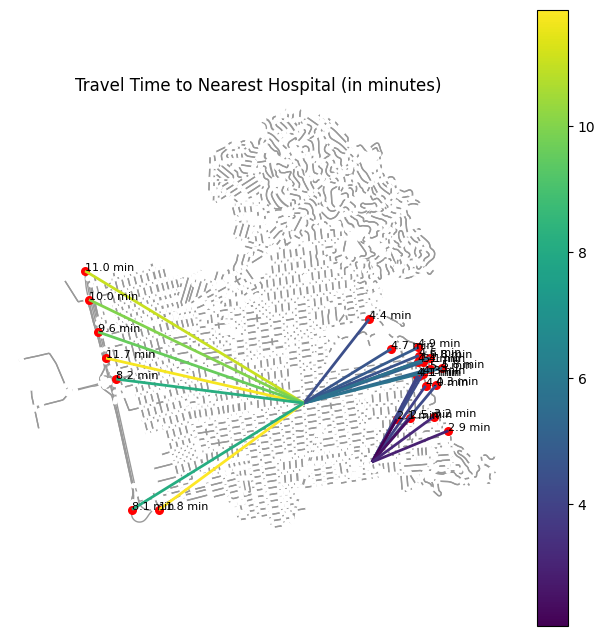

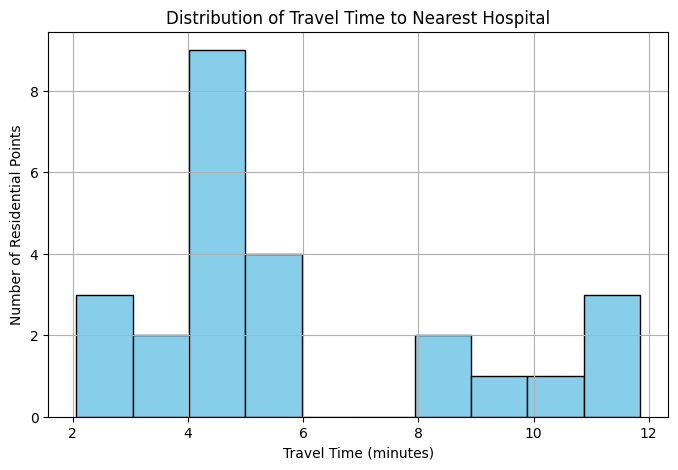

In [ ]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

# -----------------------------
# Step 1: Load network and hospitals
# -----------------------------
place = "Berkeley, California, USA"
G_drive = ox.graph_from_place(place, network_type='drive')
graph_crs = ox.project_graph(G_drive).graph['crs']

# Get hospital locations
tags = {"amenity": "hospital"}
hospitals = ox.features_from_place(place, tags)
hospitals_proj = hospitals.to_crs(graph_crs)
hospital_centroids_proj = hospitals_proj.geometry.centroid
hospital_centroids = hospital_centroids_proj.to_crs("EPSG:4326")

# Find nearest nodes for hospitals
hospital_nodes = [
    ox.distance.nearest_nodes(G_drive, p.x, p.y)
    for p in hospital_centroids.geometry if p.is_valid
]

# -----------------------------
# Step 2: Sample residential nodes and calculate travel time
# -----------------------------
residential_nodes = list(G_drive.nodes())[:25]
travel_speeds_kph = 30  # avg driving speed
travel_speeds_mps = travel_speeds_kph * 1000 / 3600

results = []
lines = []

for origin_node in residential_nodes:
    try:
        travel_times = []
        for h_node in hospital_nodes:
            path_length = nx.shortest_path_length(G_drive, origin_node, h_node, weight='length')
            time_min = path_length / (travel_speeds_mps * 60)  # convert to minutes
            travel_times.append((h_node, time_min))

        # Nearest hospital and time
        nearest_hospital_node, min_time = min(travel_times, key=lambda x: x[1])
        origin_point = Point((G_drive.nodes[origin_node]['x'], G_drive.nodes[origin_node]['y']))
        hospital_point = Point((G_drive.nodes[nearest_hospital_node]['x'], G_drive.nodes[nearest_hospital_node]['y']))
        line = LineString([origin_point, hospital_point])
        lines.append(line)

        results.append({
            "origin_node": origin_node,
            "nearest_hospital_node": nearest_hospital_node,
            "travel_time_min": min_time,
            "geometry": origin_point
        })

    except:
        continue

# Convert to GeoDataFrame
df = pd.DataFrame(results)
gdf_points = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
gdf_lines = gpd.GeoDataFrame({'geometry': lines, 'travel_time_min': df['travel_time_min']}, crs="EPSG:4326")

# -----------------------------
# Step 3: Plot travel time with labels
# -----------------------------
fig, ax = ox.plot_graph(G_drive, show=False, close=False, bgcolor='white')
gdf_lines.plot(ax=ax, column='travel_time_min', cmap='viridis', linewidth=2, legend=True)
gdf_points.plot(ax=ax, color='red', markersize=30)

# Add travel time labels
for x, y, t in zip(gdf_points.geometry.x, gdf_points.geometry.y, gdf_points.travel_time_min.round(1)):
    ax.text(x, y, f"{t} min", fontsize=8, color='black')

plt.title("Travel Time to Nearest Hospital (in minutes)")
plt.show()

# -----------------------------
# Step 4: Histogram
# -----------------------------
plt.figure(figsize=(8, 5))
gdf_points['travel_time_min'].hist(bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution of Travel Time to Nearest Hospital")
plt.xlabel("Travel Time (minutes)")
plt.ylabel("Number of Residential Points")
plt.grid(True)
plt.show()



## Travel Mode Comparison Preparation

Before comparing walk and drive accessibility, we:

- Collected **real administrative boundaries** (e.g., neighborhoods) from OpenStreetMap.
- Aggregated **average travel times** to the nearest hospital for each zone.
- Visualized these with **interactive choropleth maps** using Folium.

This sets the stage for a deeper analysis where we compare:
- Walking vs. Driving accessibility
- Equity across neighborhoods
- Infrastructure adequacy


In [ ]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import folium
from shapely.geometry import Point
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load network and hospitals
# -----------------------------
place = "Berkeley, California, USA"
G_drive = ox.graph_from_place(place, network_type='drive')
graph_crs = ox.project_graph(G_drive).graph['crs']

# Get hospital locations
tags = {"amenity": "hospital"}
hospitals = ox.features_from_place(place, tags)
hospitals_proj = hospitals.to_crs(graph_crs)
hospital_centroids_proj = hospitals_proj.geometry.centroid
hospital_centroids = hospital_centroids_proj.to_crs("EPSG:4326")

# Convert to GeoDataFrame to allow iterrows
hospital_centroids_gdf = gpd.GeoDataFrame(geometry=hospital_centroids, crs="EPSG:4326")

# Find nearest nodes for hospitals
hospital_nodes = [
    ox.distance.nearest_nodes(G_drive, p.x, p.y)
    for p in hospital_centroids.geometry if p.is_valid
]

# -----------------------------
# 2. Sample residential nodes
# -----------------------------
residential_nodes = list(G_drive.nodes())[:50]
travel_speeds_kph = 30  # driving speed
travel_speeds_mps = travel_speeds_kph * 1000 / 3600

results = []
for origin_node in residential_nodes:
    try:
        travel_times = []
        for h_node in hospital_nodes:
            path_length = nx.shortest_path_length(G_drive, origin_node, h_node, weight='length')
            time_min = path_length / (travel_speeds_mps * 60)  # minutes
            travel_times.append((h_node, time_min))

        nearest_hospital_node, min_time = min(travel_times, key=lambda x: x[1])
        origin_point = Point((G_drive.nodes[origin_node]['x'], G_drive.nodes[origin_node]['y']))

        results.append({
            "origin_node": origin_node,
            "travel_time_min": min_time,
            "geometry": origin_point
        })

    except:
        continue

# Convert to GeoDataFrame
df = pd.DataFrame(results)
gdf_points = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# -----------------------------
# 3. Get real admin boundaries from OSM (e.g. neighborhoods)
# -----------------------------
admin_tags = {"admin_level": "10", "boundary": "administrative"}
admin_boundaries = ox.features_from_place(place, admin_tags)
admin_boundaries = admin_boundaries[admin_boundaries.geometry.type.isin(["Polygon", "MultiPolygon"])]
admin_boundaries = admin_boundaries.to_crs("EPSG:4326")

# Spatial join: assign admin zone to each residential point
gdf_joined = gpd.sjoin(gdf_points, admin_boundaries, how='left', predicate='within')

# Group by zone name and calculate avg travel time
zone_avg = gdf_joined.groupby('name', observed=True)['travel_time_min'].mean().reset_index()

# Merge with admin geometry
choropleth = admin_boundaries.merge(zone_avg, on='name')

# -----------------------------
# 4. Interactive Choropleth Map with Folium
# -----------------------------
m = folium.Map(location=[37.87, -122.27], zoom_start=13, tiles='cartodbpositron')

# Add choropleth layer
folium.Choropleth(
    geo_data=choropleth,
    name='Travel Time Choropleth',
    data=choropleth,
    columns=['name', 'travel_time_min'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.4,
    legend_name='Avg Travel Time to Nearest Hospital (min)'
).add_to(m)

# Add hospital markers
for _, row in hospital_centroids_gdf.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.Icon(color='red', icon='plus-sign'),
        popup="Hospital"
    ).add_to(m)

# Add residential markers with travel time popups
for _, row in gdf_points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=f"{row.travel_time_min:.1f} min"
    ).add_to(m)

from folium import Element
# Add custom legend for markers
legend_html = '''
<div style="position: fixed;
     bottom: 50px; left: 50px; width: 200px; height: 90px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding: 10px;">
     <b>Legend</b><br>
     <i class="fa fa-plus" style="color:red"></i> Hospital<br>
     <i class="fa fa-circle" style="color:blue"></i> Residential Point
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))


m


#Isochrone Map
An isochrone is a geographic area that shows how far you can travel within a certain amount of time from a specific starting point, given a mode of transportation (e.g., walking, driving, biking).

##Creating a 10-Minute Drive Isochrone

This section creates an **isochrone polygon**, which represents the area reachable within a 10-minute drive from a central location (e.g., a city center or hospital).

### Key Steps:
- Select a central node from the road network graph.
- Estimate travel distance using average driving speed (30 km/h).
- Extract a subgraph of roads within that distance using `networkx`.
- Compute a **convex hull** around the reachable nodes to form the isochrone.
- Plot the isochrone on top of the full road network.

The result is a light blue polygon showing the spatial extent reachable by car in 10 minutes.


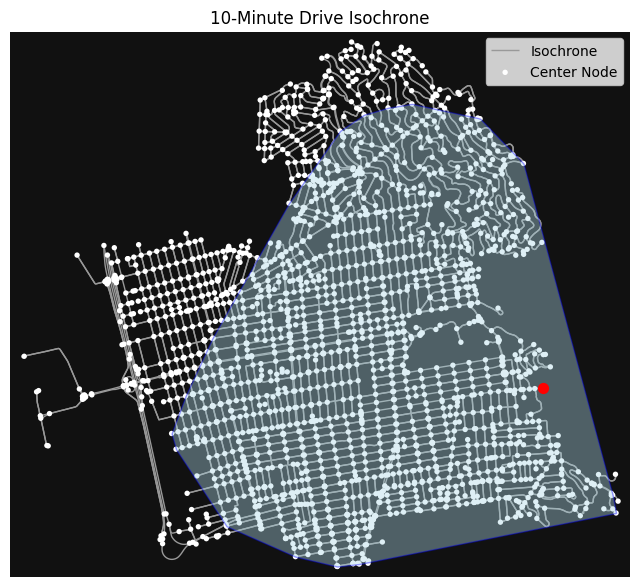

In [ ]:
from shapely.geometry import Polygon, MultiPolygon, MultiPoint, Point
import networkx as nx
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox

# Choose a central node (can be city center or a hospital)
center_node = list(G_drive.nodes())[0]

# Define travel speed (m/min) — 30 km/h ~ 500 m/min
travel_speed = 500
time_limit = 10  # in minutes
travel_distance = travel_speed * time_limit

# Get subgraph within distance
subgraph = nx.ego_graph(G_drive, center_node, radius=travel_distance, distance='length')

# Extract isochrone polygon
node_points = [(data['x'], data['y']) for node, data in subgraph.nodes(data=True)]
iso_poly = MultiPoint(node_points).convex_hull

# Create a GeoSeries for the isochrone
iso_gdf = gpd.GeoSeries([iso_poly], crs="EPSG:4326")

# Create a GeoSeries for the center point
center_point = Point(G_drive.nodes[center_node]['x'], G_drive.nodes[center_node]['y'])
center_gdf = gpd.GeoSeries([center_point], crs="EPSG:4326")

# Plot everything
fig, ax = ox.plot_graph(G_drive, show=False, close=False)
iso_gdf.plot(ax=ax, facecolor='lightblue', edgecolor='blue', alpha=0.4)
center_gdf.plot(ax=ax, color='red', markersize=50, label="Center Node")

# Add title and legend
plt.title("10-Minute Drive Isochrone")
plt.legend(["Isochrone", "Center Node"])
plt.show()


#Network Centrality

Network centrality refers to how important or "central" a node (e.g., an intersection or road junction) is within a network. It helps you identify the key connectors or critical points in a spatial (road) network.

***A node has high betweenness centrality if many shortest routes pass through it.***

##Why It Matters (Urban Use Cases):


*   Traffic bottlenecks: High-centrality nodes may experience congestion.
*   Emergency planning: Critical intersections for ambulance or fire access.
*   Infrastructure resilience: Identifying vulnerable single points of failure.
*   Transit planning: Prioritize highly connected areas for public transport.

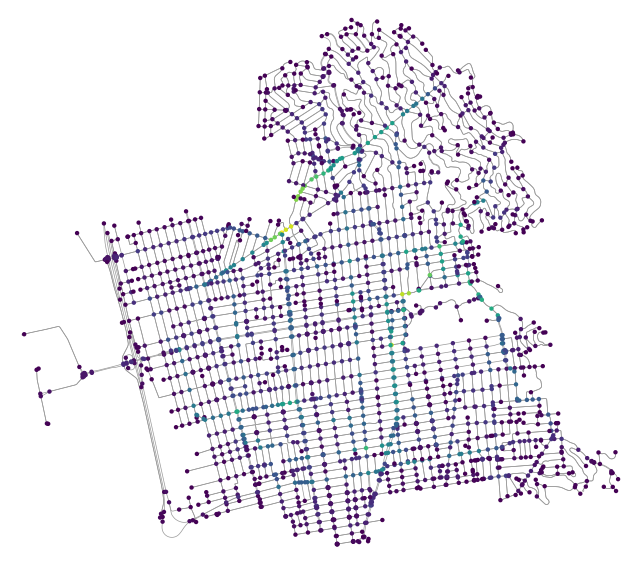

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
# Betweenness centrality (can take a while on large networks)
bc = nx.betweenness_centrality(G_drive, weight='length')
ox.plot_graph(G_drive, node_color=list(bc.values()), node_size=10, edge_linewidth=0.5, bgcolor='white')


The network layout represents the street grid of Berkeley, California. Most nodes are purple, meaning they have low centrality — they aren’t major connectors.

A few yellow-green nodes stand out — these are critical intersections where a lot of shortest paths pass through. They likely:


*   Connect major neighborhoods
*   Lie on main roads or thoroughfares
*   Are potential bottlenecks in urban mobility



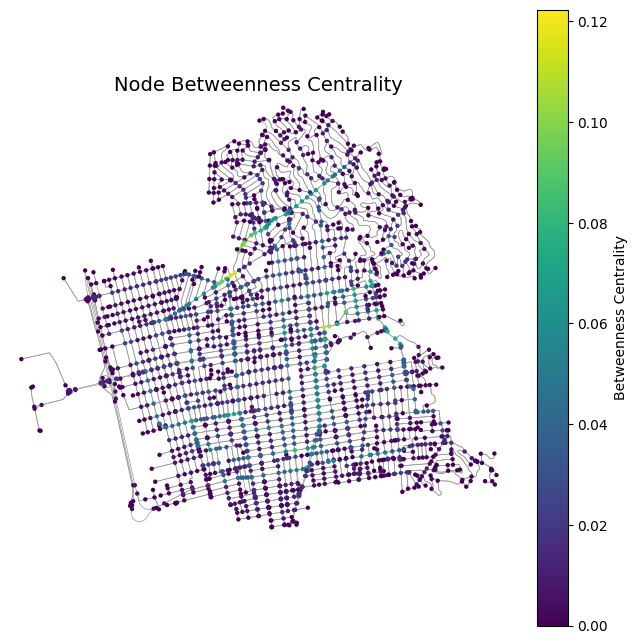

=== Top 10 Nodes by Betweenness Centrality ===
           betweenness
node                  
53019155      0.122310
53019157      0.114022
53019159      0.113947
53096076      0.111975
53055195      0.110024
53055198      0.104671
53072364      0.099477
58443326      0.099438
53072365      0.098679
261735947     0.098243


In [ ]:
import osmnx as ox
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Compute betweenness centrality ---
bc = nx.betweenness_centrality(G_drive, weight='length')

# --- 2) Store results in DataFrame for table ---
bc_df = pd.DataFrame.from_dict(bc, orient="index", columns=["betweenness"])
bc_df.index.name = "node"
bc_df_sorted = bc_df.sort_values("betweenness", ascending=False)

# --- 3) Prepare color mapping ---
node_colors = list(bc.values())

# --- 4) Plot with matplotlib control (colorbar) ---
fig, ax = ox.plot_graph(
    G_drive,
    node_color=node_colors,
    node_size=10,
    edge_linewidth=0.5,
    bgcolor="white",
    show=False,
    close=False
)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm._A = []  # required for older Matplotlib
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Betweenness Centrality")

plt.title("Node Betweenness Centrality", fontsize=14)
plt.show()

# --- 5) Show top 10 nodes as table ---
print("=== Top 10 Nodes by Betweenness Centrality ===")
print(bc_df_sorted.head(10))


#Overlay Points of Interest (e.g., Hospitals) on Network

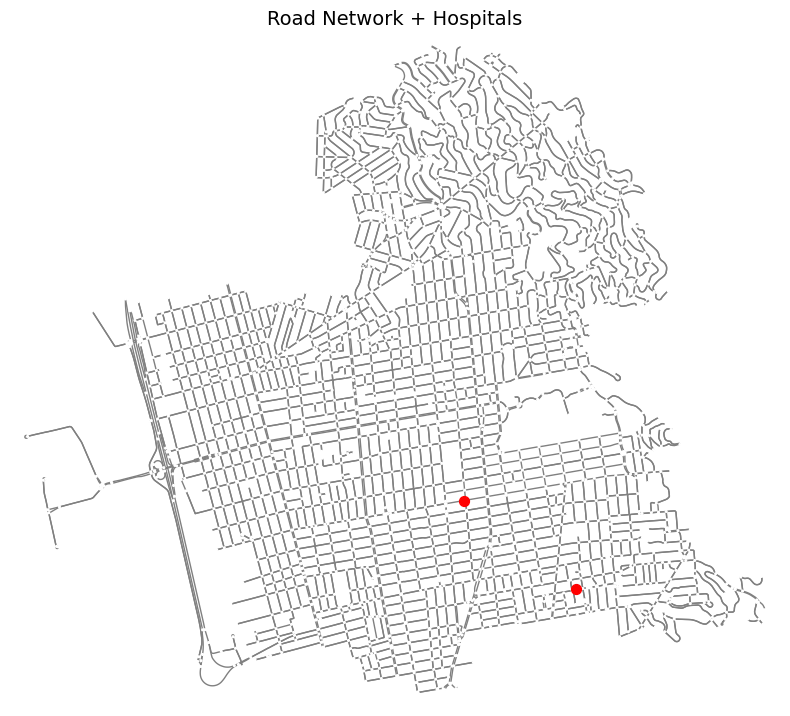

In [ ]:
# Get hospital locations from OSM
tags = {"amenity": "hospital"}
hospitals = ox.features_from_place(place, tags)

# Filter valid geometries
hospitals = hospitals[hospitals.geometry.type.isin(["Point", "Polygon", "MultiPolygon"])]

# Reproject hospital geometries before computing centroids
hospitals_proj = hospitals.to_crs(G_proj.graph['crs'])

# Compute centroids (now in meters)
hospital_pts = hospitals_proj.geometry.centroid

# Plot network + hospitals
fig, ax = ox.plot_graph(G_proj, show=False, close=False, bgcolor="white", node_size=5, edge_color="gray")
gpd.GeoSeries(hospital_pts).plot(ax=ax, color="red", markersize=50)
plt.title("Road Network + Hospitals", fontsize=14)
plt.tight_layout()
plt.show()


#Travel Time Estimation

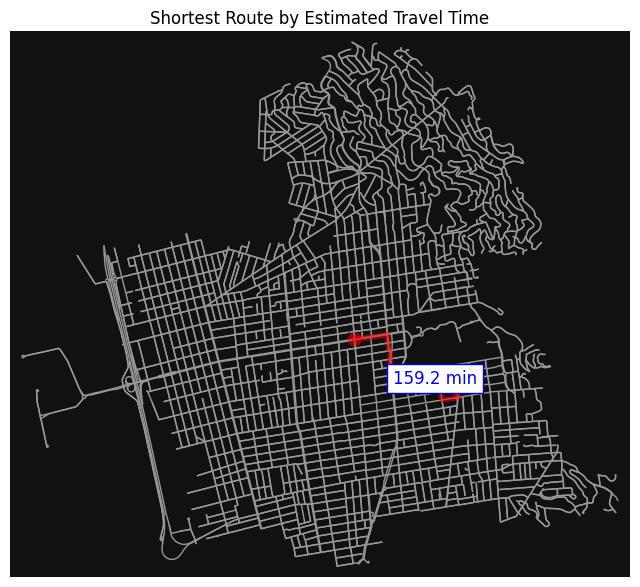

In [ ]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

# 1. Load the road network
place = "Berkeley, California, USA"
G_drive = ox.graph_from_place(place, network_type='drive')

# 2. Assign speeds based on road type
# Define default speeds (in kph) by road class
default_speeds = {
    "motorway": 100,
    "trunk": 80,
    "primary": 60,
    "secondary": 50,
    "tertiary": 40,
    "residential": 30,
    "unclassified": 30,
    "service": 20,
}

# Estimate travel time
for u, v, k, data in G_drive.edges(keys=True, data=True):
    highway = data.get("highway", "residential")
    if isinstance(highway, list):
        highway = highway[0]
    speed_kph = default_speeds.get(highway, 30)
    speed_mps = speed_kph * 1000 / 3600
    data["travel_time"] = data["length"] / speed_mps

# 3. Choose realistic points in Berkeley
origin_point = (37.8716, -122.2727)       # Near UC Berkeley
destination_point = (37.8663, -122.2580)  # Nearby location

origin = ox.distance.nearest_nodes(G_drive, X=origin_point[1], Y=origin_point[0])
destination = ox.distance.nearest_nodes(G_drive, X=destination_point[1], Y=destination_point[0])

# 4. Compute shortest path
route = nx.shortest_path(G_drive, origin, destination, weight='travel_time')

# 5. Sum total travel time
travel_time = sum(
    G_drive[u][v][0]['travel_time'] for u, v in zip(route[:-1], route[1:])
)

# 6. Plot with label
fig, ax = ox.plot_graph_route(G_drive, route, route_linewidth=4, node_size=0, show=False, close=False)
mid_node = route[len(route)//2]
x, y = G_drive.nodes[mid_node]['x'], G_drive.nodes[mid_node]['y']
ax.text(x, y, f"{travel_time:.1f} min", fontsize=12, color="blue", bbox=dict(facecolor='white', edgecolor='blue'))
plt.title("Shortest Route by Estimated Travel Time")
plt.show()


#Comparing Modes

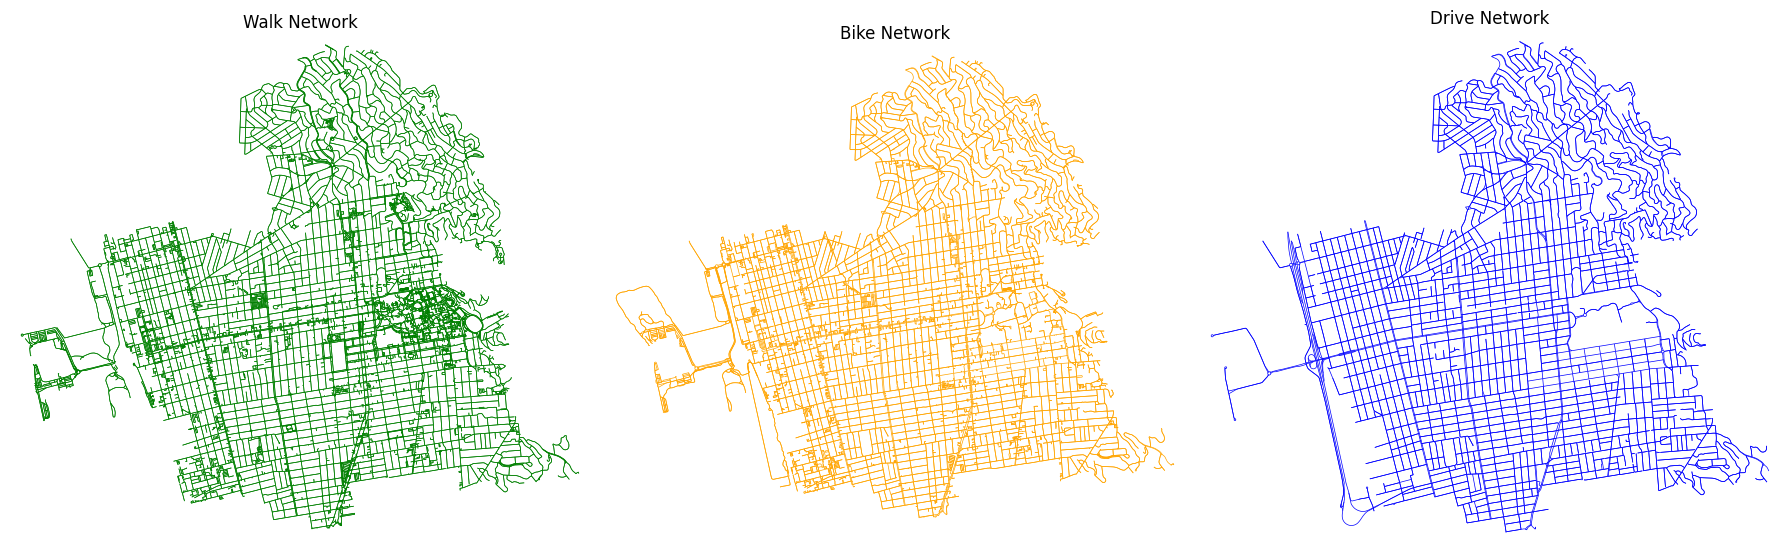

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Walk
ox.plot_graph(G_walk, ax=axs[0], node_size=0, edge_color='green', edge_linewidth=0.5, show=False, close=False)
axs[0].set_title("Walk Network")

# Bike
ox.plot_graph(G_bike, ax=axs[1], node_size=0, edge_color='orange', edge_linewidth=0.5, show=False, close=False)
axs[1].set_title("Bike Network")

# Drive
ox.plot_graph(G_drive, ax=axs[2], node_size=0, edge_color='blue', edge_linewidth=0.5, show=False, close=False)
axs[2].set_title("Drive Network")

plt.tight_layout()
plt.show()


#You can check more examples from https://github.com/gboeing/osmnx